In [1]:
import pandas as pd
from utils import download_data
from data_preparation import data_preparation, train_val_test_split, find_sch_match
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import re
from models import logistic_regression, random_guess
from evaluation import metric_auc, accuracy

In [2]:
data = download_data(user='byfan', password='props urban aging vocally patio portside',
                     tb_name='sketch.train_data_2')

Connected!



In [3]:
oh = download_data(user='byfan', password='props urban aging vocally patio portside',
                     tb_name='sketch.ode_school')

Connected!



In [4]:
data.head(2)

,student_lookup,grade,school_year,days_absent,graduation_date,discipline_incidents,withdraw_reason,district_withdraw_date,ethnicity,district,school_name,intervention_count,eighth_math_ss,eighth_read_ss,gpa,new_gpa
0,8.0,3.0,2015,5.0,None,1.0,did not withdraw,None,W,Maysville,Maysville Elementary School,1,None,None,NaN,NaN
1,8.0,3.0,2015,5.0,None,1.0,did not withdraw,None,W,Maysville,Maysville Elementary School,1,None,None,NaN,NaN


In [5]:
oh.head(2)

,irn,district_name,county,typology_2013,enrollment,median_income,student_poverty,pct_minority,typology,schtype,...,fed_rev_per_pupil,fed_rev_as_pct_of_tot,tot_rev_per_pupil,formula_funding_per_pupil,formula_funding_as_pct_of_income_tax_liability,salaries_as_pct_of_operating_expend,fringe_benefits_as_pct_of_operating_expend,purchased_services_as_pct_of_operating_expend,suppliesmaterials_as_pct_of_operating_expend,other_expenses_as_pct_of_operating_expend
0,45187,Ada Exempted Village,Hardin,3,941,31392,0.33,0.05,3 - Small Town - Low Student Poverty,3.0,...,617.81,0.05,13232.91,6167.77,2.02,0.55,0.22,0.15,0.02,0.05
1,49494,Adena Local,Ross,2,1230,31808,0.37,0.07,2 - Rural - Average Student Poverty,2.0,...,750.03,0.06,11805.23,6803.27,2.79,0.52,0.24,0.19,0.04,0.01


In [6]:
df = data

# Variables in 8th grade
df.loc[df['grade']==8,'gpa_8'] = df['new_gpa']
df.loc[df['grade']==8,'abs_8'] = df['days_absent']
df.loc[df['grade']==8,'int_8'] = df['intervention_count']


# Cohort and aux grade_min and grade_max
df.loc[df['grade']==9,'cohort'] = df['school_year']
df['grade_max'] = df['grade']
df['grade_min'] = df['grade']

df['graduation_date'] = pd.to_datetime(df['graduation_date'])

# Groupby each student
df = df.groupby('student_lookup').agg({'ethnicity':'first', 'graduation_date':'max', 'district':'first',
                                            'withdraw_reason':'last', 'gpa_8':'mean', 'abs_8':'mean', 'int_8':'mean',
                                                   'grade_min':'min', 'grade_max':'max', 'cohort':'first'})

df = find_sch_match(df, 'district', oh, 'district_name')


In [7]:
df.head(2)

,ethnicity,graduation_date,withdraw_reason,gpa_8,abs_8,int_8,grade_min,grade_max,cohort,ode_distr,...,fed_rev_per_pupil,fed_rev_as_pct_of_tot,tot_rev_per_pupil,formula_funding_per_pupil,formula_funding_as_pct_of_income_tax_liability,salaries_as_pct_of_operating_expend,fringe_benefits_as_pct_of_operating_expend,purchased_services_as_pct_of_operating_expend,suppliesmaterials_as_pct_of_operating_expend,other_expenses_as_pct_of_operating_expend
0,W,NaT,did not withdraw,NaN,NaN,NaN,0.0,3.0,NaN,River View Local,...,850.21,0.07,12035.66,4159.51,1.54,0.52,0.26,0.17,0.03,0.02
1,W,NaT,transferred - in state,NaN,NaN,NaN,3.0,3.0,NaN,Maysville Local,...,1123.24,0.10,11040.47,8336.30,3.41,0.51,0.23,0.23,0.03,0.01


In [8]:
data_final = data_preparation(data, oh, args=1)

gpa_8                                            float64
abs_8                                            float64
int_8                                            float64
cohort                                           float64
A                                                  uint8
                                                  ...   
fringe_benefits_as_pct_of_operating_expend       float64
purchased_services_as_pct_of_operating_expend    float64
suppliesmaterials_as_pct_of_operating_expend     float64
other_expenses_as_pct_of_operating_expend        float64
graduated                                        float64
Length: 86, dtype: object


In [9]:
data_final.columns

Index(['gpa_8', 'abs_8', 'int_8', 'cohort', 'A', 'B', 'H', 'I', 'M', 'W',
       'typology_2013', 'enrollment', 'median_income', 'student_poverty',
       'pct_minority', 'schtype', 'square_mileage', 'pupil_density',
       'tot_average_daily_membership', 'tot_yearend_enrollment',
       'asian_students_as_pct_of_tot',
       'pacific_islander_students_as_pct_of_tot',
       'black_students_as_pct_of_tot',
       'american_indian_alaskan_native_students_as_pct_of_tot',
       'hispanic_students_as_pct_of_tot', 'white_students_as_pct_of_tot',
       'multiracial_students_as_pct_of_tot', 'pct_of_disadvantaged_students_',
       'pct_of_students_with_limited_english_proficiency',
       'pct_of_students_with_disability', 'classroom_teacher_average_salary',
       'pct_of_teachers_with_04_years_experience',
       'pct_of_teachers_with_410_years_experience',
       'pct_of_teachers_with_10_years_experience',
       'fte_number_of_administrators', 'administrator_average_salary',
       'pup

In [10]:
train_data, test_data = train_val_test_split(data_final, 2007, 2011)

In [11]:
model = logistic_regression
clf = model(train_data, args=[0.9])

Model coefs:  [[ 1.09926417e-02 -7.60454259e-02  2.47645805e-03  5.82765599e-05
  -7.55951493e-05 -2.23398213e-05  1.03168127e-05 -4.66225627e-04
   4.89661689e-04 -4.91409672e-05 -2.15445765e-02  9.26583650e-03
   2.25270786e-07 -5.77141880e-06 -4.91409672e-05 -2.02328152e-03
  -1.34235681e-03 -3.28298321e-02 -1.23380274e-02  1.39846732e-07
   0.00000000e+00 -1.62928519e-06  0.00000000e+00 -2.60532667e-07
   5.02543631e-06 -4.31202038e-06  9.85591119e-06  3.60102603e-08
  -1.26823906e-07 -8.15174811e-03 -6.76655421e-06  1.20017053e-06
   4.53787827e-06 -1.89077366e-04 -7.57712299e-03 -1.13259281e-03
   1.65509488e-03 -3.63292852e-06  1.80731108e-06  5.45147109e-07
   2.53351461e-06  1.50784470e-06  3.68532177e-02 -1.10473482e-03
  -3.29883762e-03  1.20012333e-03  3.48445663e-02 -1.25249857e-02
   9.18386109e-05  1.97758816e-04  1.61094467e-04 -8.92627449e-05
   0.00000000e+00  1.17343348e-06  8.23250994e-03 -9.20744020e-03
   4.61827041e-02 -2.56587523e-03 -1.20616230e-02  3.05799876e

In [35]:
def confusion_matrix(clf, test_data):
    X = test_data.drop(columns=['graduated']).values
    y = test_data['graduated'].values

    # Predictions
    y_hat = clf.predict(X)
    confusion_matrix = pd.crosstab(y, y_hat, rownames=['Actual'], colnames=['Predicted'], normalize=True)
    print (confusion_matrix)
    return(confusion_matrix)

In [14]:
train_accuracy = accuracy(clf, train_data)
print('Train accuracy: ', train_accuracy)
test_accuracy = accuracy(clf, test_data)
print('Test accuracy: ', test_accuracy)

Train accuracy:  0.856986301369863
Test accuracy:  0.811409110259685


In [16]:
metric = metric_auc(clf, test_data)
print('{}: {}'.format("AUC", metric))

AUC:  0.5234567901234567
AUC: 0.5234567901234567


Predicted       0.0       1.0
Actual                       
0.0        0.014474  0.157940
1.0        0.030651  0.796935


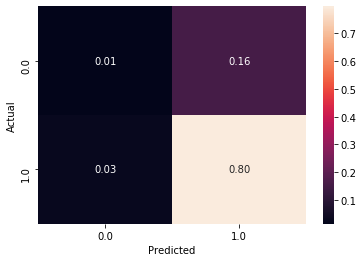

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(clf, test_data)
sns.heatmap(cm, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)